In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import tensorflow as tf
from keras.models import *
from keras.layers import *
from keras.applications.vgg16 import VGG16
from keras.regularizers import l2

from keras.applications.imagenet_utils import _obtain_input_shape
import keras.backend as K
from keras.optimizers import Adam, SGD
from keras.callbacks import *
# from keras_contrib.applications import densenet

Using TensorFlow backend.


In [2]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import re
import scipy
from PIL import Image
from skimage.transform import resize
from imageio import imread

In [3]:
# https://github.com/aurora95/Keras-FCN/blob/master/utils/loss_function.py
def softmax_sparse_crossentropy_ignoring_last_label(y_true, y_pred):
    y_pred = K.reshape(y_pred, (-1, K.int_shape(y_pred)[-1]))
    log_softmax = tf.nn.log_softmax(y_pred)

    y_true = K.one_hot(tf.to_int32(K.flatten(y_true)), K.int_shape(y_pred)[-1]+1)
    unpacked = tf.unstack(y_true, axis=-1)
    y_true = tf.stack(unpacked[:-1], axis=-1)

    cross_entropy = -K.sum(y_true * log_softmax, axis=1)
    cross_entropy_mean = K.mean(cross_entropy)

    return cross_entropy_mean


# Softmax cross-entropy loss function for coco segmentation
# and models which expect but do not apply sigmoid on each entry
# tensorlow only
def binary_crossentropy_with_logits(ground_truth, predictions):
    return K.mean(K.binary_crossentropy(ground_truth,
                                        predictions,
                                        from_logits=True),
                  axis=-1)
def sparse_accuracy_ignoring_last_label(y_true, y_pred):
    nb_classes = K.int_shape(y_pred)[-1]
    y_pred = K.reshape(y_pred, (-1, nb_classes))

    y_true = K.one_hot(tf.to_int32(K.flatten(y_true)),
                       nb_classes + 1)
    unpacked = tf.unstack(y_true, axis=-1)
    legal_labels = ~tf.cast(unpacked[-1], tf.bool)
    y_true = tf.stack(unpacked[:-1], axis=-1)

    return K.sum(tf.to_float(legal_labels & K.equal(K.argmax(y_true, axis=-1), K.argmax(y_pred, axis=-1)))) / K.sum(tf.to_float(legal_labels))


In [4]:
model  = load_model('checkpoints/fcn.epoch05.h5', custom_objects={'binary_crossentropy_with_logits': binary_crossentropy_with_logits})

In [5]:
np.random.seed(10)
road_imgs_gt = glob.glob(os.path.join('./data', 'data_road/training', 'gt_image_2', '*_road_*.png'))
np.random.shuffle(road_imgs_gt)
val_gt_arr = road_imgs_gt[:16]
val_img_arr = [x.replace('gt_image_2', 'image_2').replace('_road_', '_').replace('_lane_', '_') for x in val_gt_arr]
train_gt_arr = road_imgs_gt[16:]
train_img_arr = [x.replace('gt_image_2', 'image_2').replace('_road_', '_').replace('_lane_', '_') for x in train_gt_arr]
test_imgs = glob.glob(os.path.join('./data', 'data_road/testing', 'image_2', '*.png'))

In [101]:
image_shape = (64,64,3)
def drawmask(img_file, image_shape):
    img_arr_original = imread(img_file)
    original_imshape = img_arr_original.shape
    img_arr = resize(img_arr_original, image_shape)
    prediction = model.predict(np.array([img_arr]))
    segmentation = np.argmax(prediction, axis=-1).astype(np.uint8)
    flattened = np.expand_dims(np.squeeze(segmentation).flatten(), axis=-1)
    flattened_inv = 1- flattened
    mask = np.dot(flattened_inv, np.array([[0, 255, 0, 127]])).astype(np.uint8)
    mask = np.reshape(mask, (image_shape[0], image_shape[1],4))
    mask_img = Image.fromarray(mask, mode="RGBA")
    mask_img = mask_img.resize((original_imshape[1], original_imshape[0]))
    street_im = Image.fromarray(img_arr_original)
    street_im.paste(mask_img, mask=mask_img)
    
    return street_im
    

/Users/wwymak/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


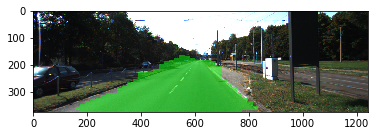

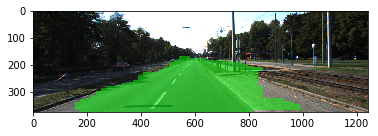

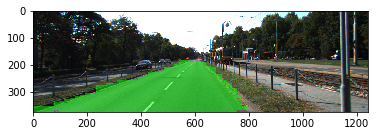

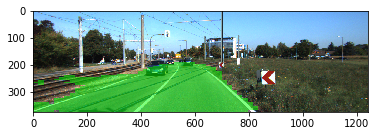

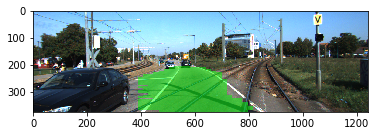

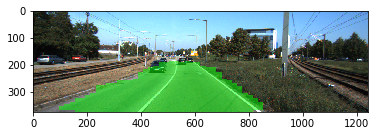

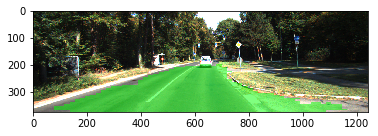

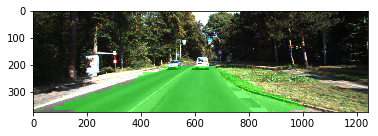

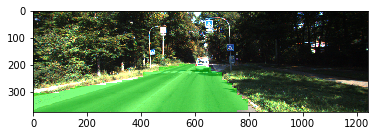

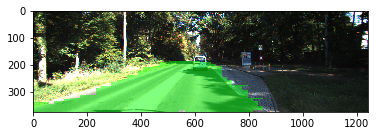

In [107]:
for i in range(10):
    outImg = drawmask(test_imgs[i], image_shape)
    plt.figure()
    plt.imshow(outImg)

In [9]:
img_arr_original = imread(image_file_real)
original_imshape = img_arr_original.shape
img_arr = resize(img_arr_original, image_shape)
prediction = model.predict(np.array([img_arr]))
# prediction= np.squeeze(prediction)
# segmentation = np.argmax(prediction, axis=-1).astype(np.uint8)

/Users/wwymak/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [108]:
def train_generator(files_list, gt_list, batch_size, image_shape):

    background_color = np.array([1, 0, 0])
    images = []
    gt_images = []

    while True:
        for i in range(batch_size):
            index = np.random.choice(len(files_list), replace=False)
            image_file = files_list[index]
            gt_file = gt_list[index]
            gt_image = resize(imread(gt_file), image_shape)
            
            image = resize(imread(image_file), image_shape)

            gt_bg_mask = np.all(gt_image == background_color, axis=2)
            gt_image_bg = np.zeros(shape=(image_shape[0], image_shape[1]))
            gt_image_fg = np.ones(shape=(image_shape[0], image_shape[1]))


            gt_image_fg[gt_bg_mask] = 0
            gt_image_bg[gt_bg_mask] = 1
            
            gt_onehot = np.stack((gt_image_fg, gt_image_bg), axis=-1)
#             gt_onehot = np.moveaxis(gt_onehot, 0, -1)
            
            images.append(image)
            gt_images.append(gt_onehot)

#         yield images, gt_onehot
        yield np.array(images), np.array(gt_images)

In [109]:
t_generator = train_generator(train_img_arr, train_gt_arr, 2, image_shape)
#     val_generator = train_generator(val_img_arr, val_gt_arr, batch_size, image_shape)

In [110]:
data = t_generator.__next__()

/Users/wwymak/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [115]:
data[1][0].shape

(64, 64, 2)

In [57]:
def mean_IoU(y_true, y_pred):
	s = K.shape(y_true)

	# reshape such that w and h dim are multiplied together
	y_true_reshaped = K.reshape( y_true, tf.stack( [-1, s[1]*s[2], s[-1]] ) )
	y_pred_reshaped = K.reshape( y_pred, tf.stack( [-1, s[1]*s[2], s[-1]] ) )

	# correctly classified
	clf_pred = K.one_hot( K.argmax(y_pred_reshaped), s[-1])
	equal_entries = K.cast(K.equal(clf_pred,y_true_reshaped), dtype='float32') * y_true_reshaped

	intersection = K.sum(equal_entries, axis=1)
	union_per_class = K.sum(y_true_reshaped,axis=1) + K.sum(y_pred_reshaped,axis=1)

	iou = intersection / (union_per_class - intersection)
	iou_mask = tf.is_finite(iou)
	iou_masked = tf.boolean_mask(iou,iou_mask)

	return K.mean( iou_masked )

In [116]:
prediction = model.predict(np.array([data[0][0]]))

In [149]:
a = prediction[0][:,:, 0]
a 

array([[-3.06915   , -4.0212026 , -3.9804761 , ..., -6.143816  ,
        -7.017242  , -8.052373  ],
       [-3.6982052 , -4.737586  , -5.0960836 , ..., -7.9406614 ,
        -7.7564607 , -8.39003   ],
       [-4.456032  , -4.793514  , -5.2848186 , ..., -7.8231907 ,
        -7.527121  , -6.5790014 ],
       ...,
       [-2.6478615 , -3.1110172 , -3.1457698 , ..., -1.6469227 ,
        -2.1208675 , -1.8291967 ],
       [-2.1482866 , -2.755843  , -3.1457691 , ..., -1.9205174 ,
        -1.8380466 , -1.4051619 ],
       [-1.0823407 , -1.3191086 , -1.6005677 , ..., -1.3606973 ,
        -1.2354829 , -0.96532106]], dtype=float32)

In [130]:
y_true = data[1][0]
segmentation = np.argmax(prediction, axis=-1).astype(np.uint8)

In [135]:
a = np.equal(np.squeeze(segmentation), np.argmax(y_true, axis=-1).astype(np.uint8))

In [136]:
a

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [133]:
np.argmax(y_true, axis=-1).astype(np.uint8).shape

(64, 64)